In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pmd

# Time Series Modelling #

## PMD ARIMA ##

In [100]:
LFBgts = pd.read_csv('../Assets/LFBgts.csv')

In [101]:
LFBgts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43498 entries, 0 to 43497
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ob_time          43498 non-null  object 
 1   DateOfCall       43498 non-null  object 
 2   HourOfCall       43498 non-null  int64  
 3   callouts         43498 non-null  int64  
 4   cld_ttl_amt_id   43498 non-null  float64
 5   islight          43498 non-null  int64  
 6   max_gust_speed   43498 non-null  float64
 7   prcp_amt         43498 non-null  float64
 8   rltv_hum         43498 non-null  float64
 9   stn_pres         43498 non-null  float64
 10  visibility       43498 non-null  float64
 11  wind_dirc        43498 non-null  int64  
 12  wind_speed       43498 non-null  float64
 13  wmo_hr_sun_dur   43498 non-null  float64
 14  holiday          43498 non-null  int64  
 15  weekend          43498 non-null  int64  
 16  air_temperature  43498 non-null  float64
 17  tempsq      

In [102]:

LFBgts.ob_time = pd.to_datetime(LFBgts.ob_time)
LFBgts.set_index('ob_time', inplace = True, drop=True)
LFBgts=LFBgts.sort_index(ascending = True)
LFBgts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43498 entries, 2016-01-01 00:00:00 to 2020-12-31 23:00:00
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DateOfCall       43498 non-null  object 
 1   HourOfCall       43498 non-null  int64  
 2   callouts         43498 non-null  int64  
 3   cld_ttl_amt_id   43498 non-null  float64
 4   islight          43498 non-null  int64  
 5   max_gust_speed   43498 non-null  float64
 6   prcp_amt         43498 non-null  float64
 7   rltv_hum         43498 non-null  float64
 8   stn_pres         43498 non-null  float64
 9   visibility       43498 non-null  float64
 10  wind_dirc        43498 non-null  int64  
 11  wind_speed       43498 non-null  float64
 12  wmo_hr_sun_dur   43498 non-null  float64
 13  holiday          43498 non-null  int64  
 14  weekend          43498 non-null  int64  
 15  air_temperature  43498 non-null  float64
 16  tempsq           43498 

In [103]:
def autocorr_plots(y, lags=20, alpha=0.05):
    """
    Plot autocorrelations and partial autocorrelations
    Arguments:
    y: Time series
    lags: Number of lags to plot
    alpha: Confidence level for random noise
    """

    se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(y))

    fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

    plot_acf(y, lags=lags, alpha=alpha, ax=ax[0])
    ax[0].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)

    plot_pacf(y, lags=lags, alpha=alpha, ax=ax[1], method='ywmle')
    ax[1].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)

    return fig, ax

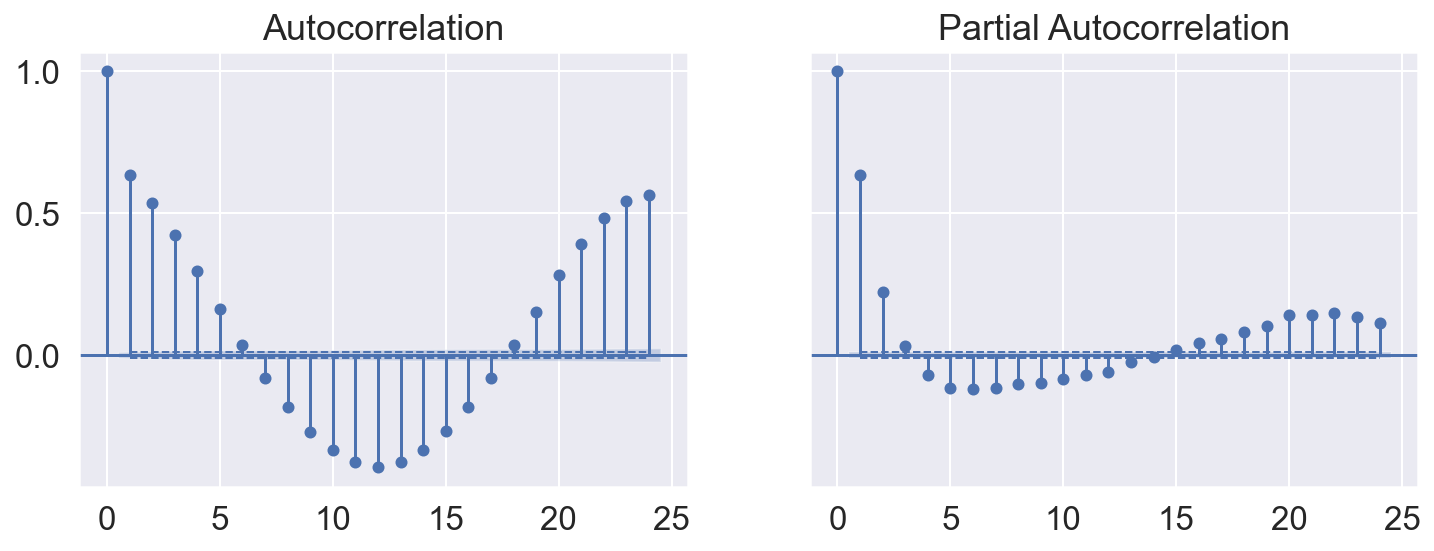

In [104]:
# Looking at Autocorrelation and Partial Autocorrelation
fig, ax = autocorr_plots(LFBgts.callouts, lags=24)

In [105]:
# Looking for optimal differencing (and seasonal differencing)
pmd.arima.ndiffs(LFBgts.callouts)

1

In [106]:
pmd.arima.nsdiffs(LFBgts.callouts, m=24)

0

In [71]:
# ARIMA model (no exogenous variables)
period = 24
model = pmd.arima.ARIMA(order=(1, 1, 1), 
                        seasonal_order=(1, 0, 1, period),
                        maxiter=500,
                        with_intercept=True)
model.fit(LFBgts.callouts)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                43498
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood             -124992.142
Date:                            Sat, 06 Mar 2021   AIC                         249996.284
Time:                                    14:55:03   BIC                         250048.367
Sample:                                         0   HQIC                        250012.705
                                          - 43498                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -4.399e-06   8.24e-05     -0.053      0.957      -0.000       0.000
ar.L1          0.2939      0.002    117.982      0.000       0.289       0.299
ma.L1         -0.9785      0.001  -1574.247      0.000      -0.980      -0.977
ar.S.L24       0.9758      0.001    676.389      0.000       0.973       0.979
ma.S.L24      -0.8310      0.003   -259.014      0.000      -0.837      -0.825
sigma2        18.3339      0.054    342.295      0.000      18.229      18.439
===================================================================================
Ljung-Box (L1) (Q):                  64.41   Jarque-Bera (JB):            353122.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

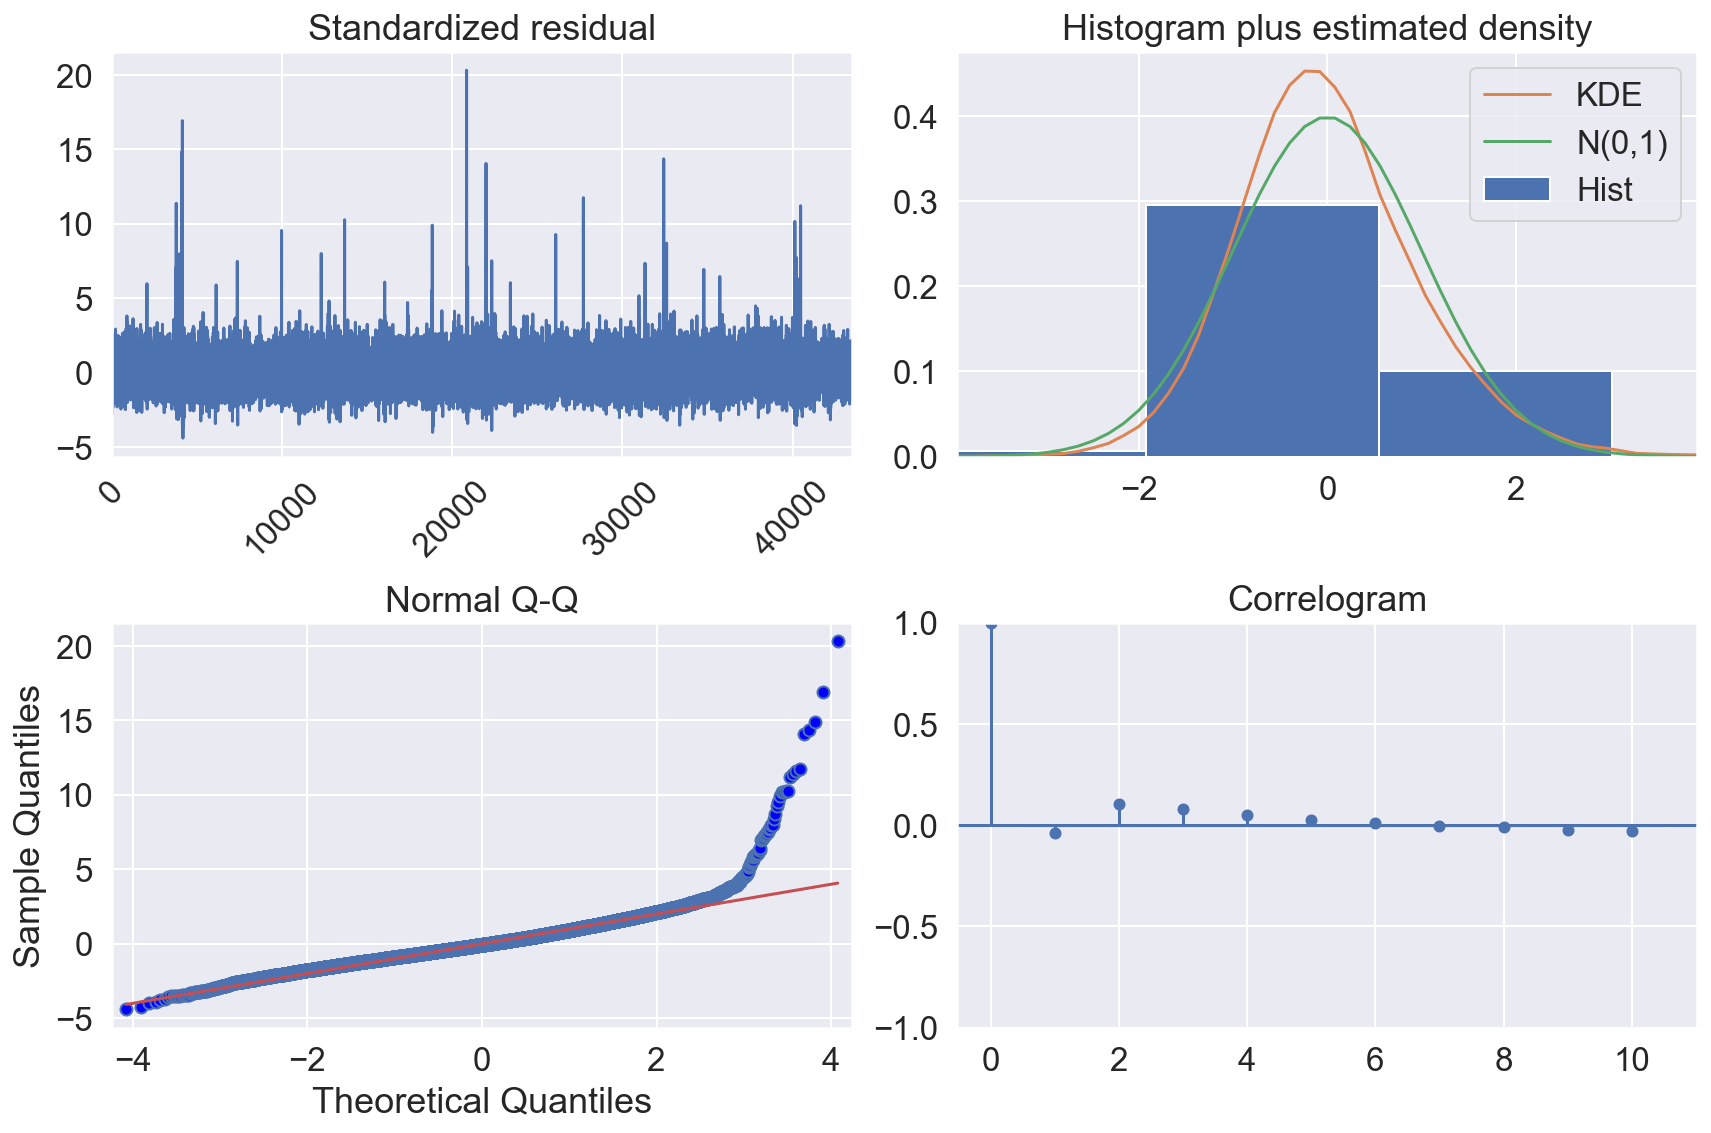

In [72]:
# Examining model results
diag_plot = model.plot_diagnostics(figsize=(12, 8))
diag_plot.axes[0].tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()

In [77]:

# forecasting
start_p = 50

# start and end indicate position from where to start and where to end forecasting
# end can be beyond the end of the observed values
# predictions are returned as numpy arrays, to cast as pandas series need to create datetime index

#preds = model.predict_in_sample(start=1, end=len(data)+50, dynamic=False)
preds, ci = model.predict_in_sample(start=1, end=len(LFBgts)+50, 
                                          return_conf_int=True, alpha=0.05)

preds_dyn = model.predict_in_sample(start=len(LFBgts)-start_p,
                            end=len(LFBgts)+50, dynamic=True)

index = pd.date_range(start=LFBgts.index[1], periods=len(LFBgts)+50, freq='H')
index_dyn = pd.date_range(start=LFBgts.index[len(LFBgts)-start_p], periods=start_p+50+1, freq='H')

preds = pd.Series(preds, index=index)
preds_dyn = pd.Series(preds_dyn, index=index_dyn)
ci = pd.DataFrame(ci, columns=['lower', 'upper'], index=index)

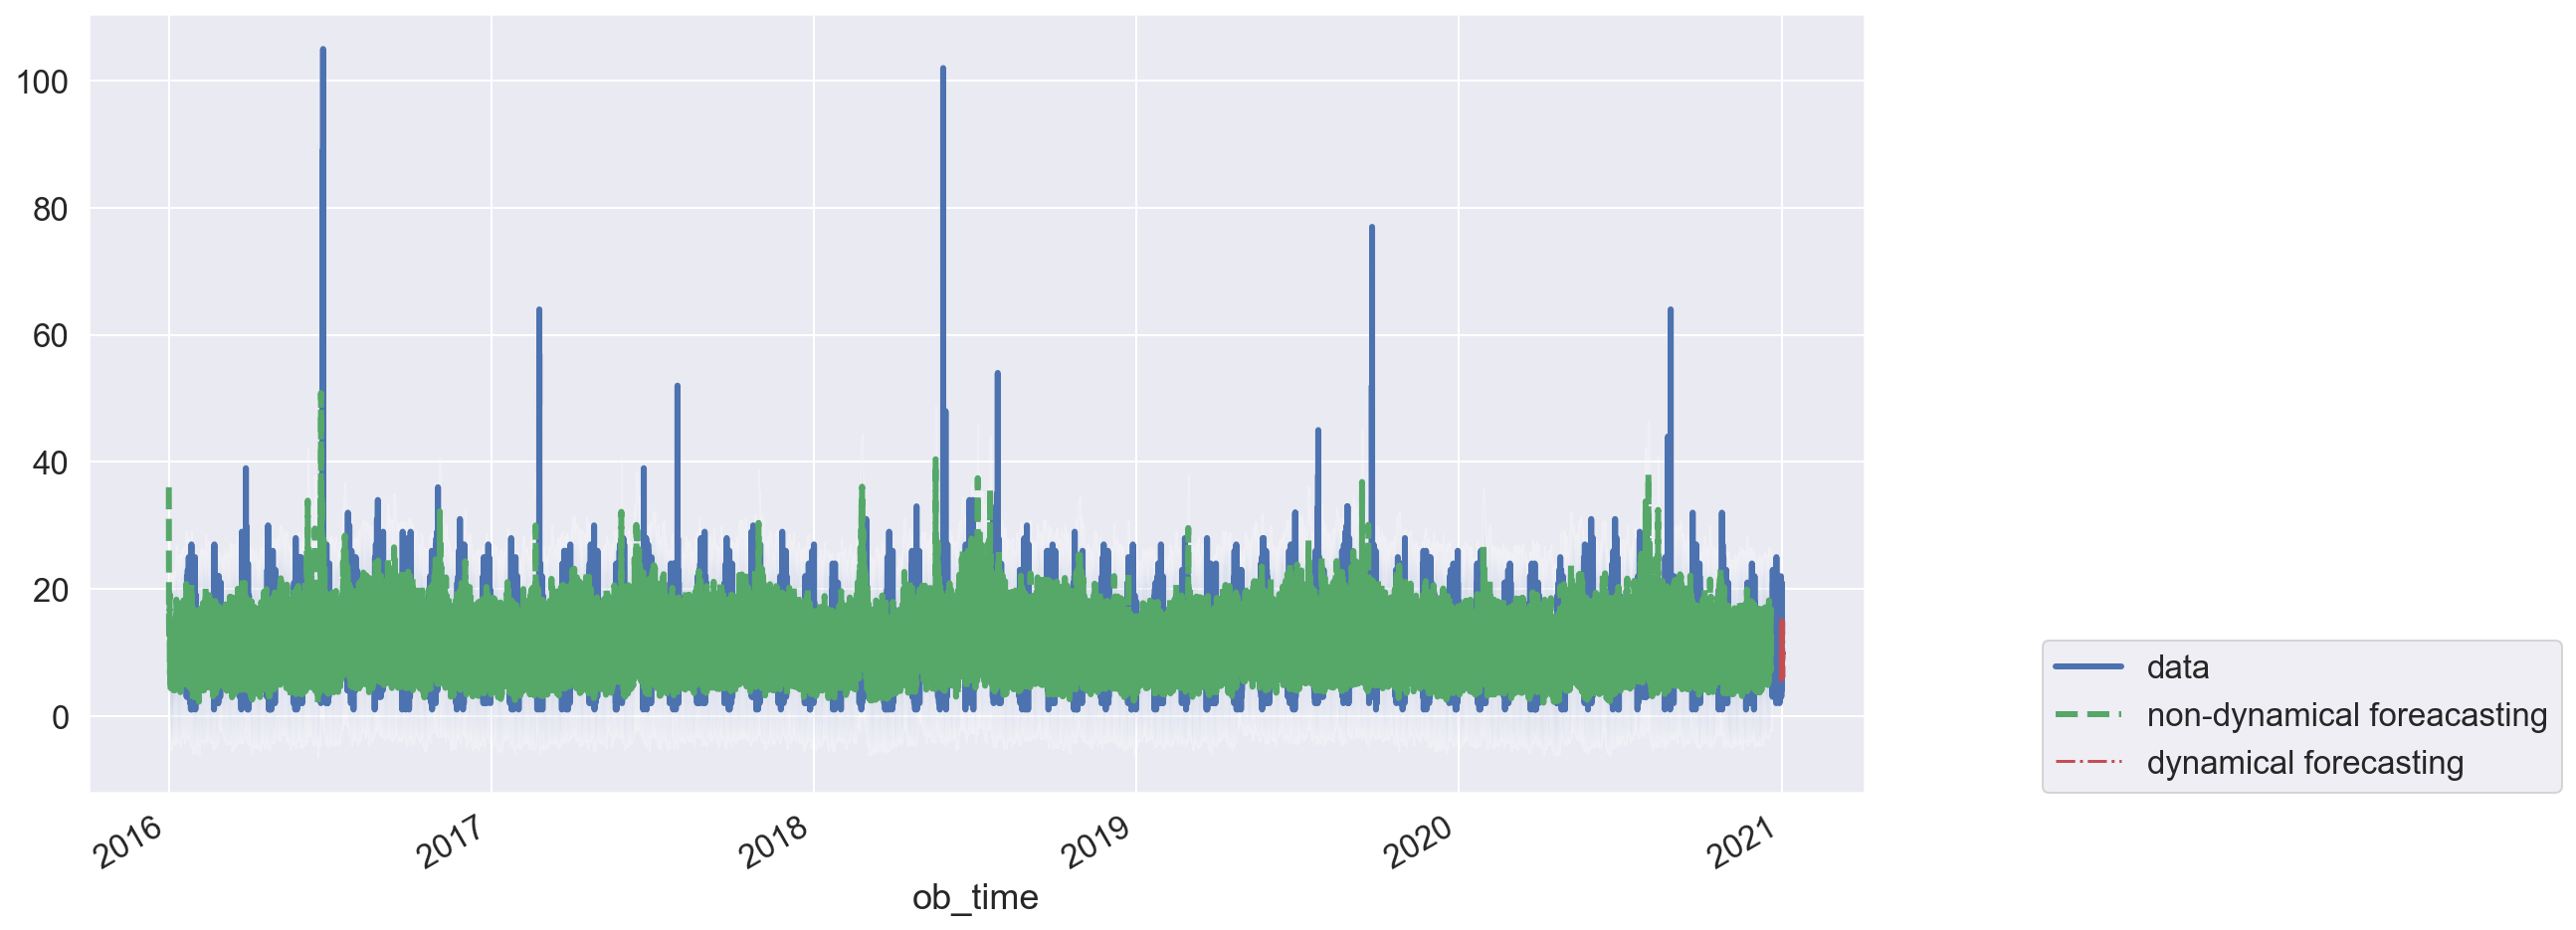

In [78]:
fig, ax = plt.subplots(figsize=(16, 8))
LFBgts1.callouts.plot(c='b', label='data', lw=3, ax=ax)
preds.plot(c='g', ls='--', lw=3, label='non-dynamical foreacasting', ax=ax)
preds_dyn.plot(c='r', ls='-.', label='dynamical forecasting', ax=ax)
i = 12
ax.fill_between(ci.index[i:], ci.iloc[i:,0], ci.iloc[i:, 1], alpha=0.3)
plt.legend(loc=[1.1, 0])
plt.show()

In [107]:
# and now with exogenous variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [108]:
LFBgts1 = LFBgts.drop(columns = ['DateOfCall', 'HourOfCall'])

In [109]:
LFBgts1dum = pd.get_dummies(
    LFBgts1, columns=['wind_dirc'])

In [110]:
list(LFBgts1dum.columns)

['callouts',
 'cld_ttl_amt_id',
 'islight',
 'max_gust_speed',
 'prcp_amt',
 'rltv_hum',
 'stn_pres',
 'visibility',
 'wind_speed',
 'wmo_hr_sun_dur',
 'holiday',
 'weekend',
 'air_temperature',
 'tempsq',
 'lockdown',
 'prioryear',
 'wind_dirc_1',
 'wind_dirc_2',
 'wind_dirc_3',
 'wind_dirc_4',
 'wind_dirc_5',
 'wind_dirc_6',
 'wind_dirc_7',
 'wind_dirc_8',
 'wind_dirc_9',
 'wind_dirc_10',
 'wind_dirc_11',
 'wind_dirc_12',
 'wind_dirc_13',
 'wind_dirc_14',
 'wind_dirc_15',
 'wind_dirc_16',
 'wind_dirc_17',
 'wind_dirc_18']

In [112]:
LFBgts2 = LFBgts1.drop(columns = ['callouts'])

In [113]:
LFBgts2.isnull().sum()

cld_ttl_amt_id     0
islight            0
max_gust_speed     0
prcp_amt           0
rltv_hum           0
stn_pres           0
visibility         0
wind_dirc          0
wind_speed         0
wmo_hr_sun_dur     0
holiday            0
weekend            0
air_temperature    0
tempsq             0
lockdown           0
prioryear          0
dtype: int64

In [114]:
scaled = scaler.fit_transform(LFBgts2)

In [115]:
scaled

array([[-1.56145242, -1.02556933, -0.25633887, ...,  0.84049586,
        -0.25424415,  2.45865739],
       [-1.56145242, -1.02556933, -0.85522535, ...,  0.87565941,
        -0.25424415,  0.99568077],
       [-1.56145242, -1.02556933, -1.15466858, ...,  1.28754813,
        -0.25424415, -0.30474289],
       ...,
       [-0.94602546, -1.02556933, -0.17648734, ...,  2.06076608,
        -0.25424415,  0.18291599],
       [-0.94602546, -1.02556933, -0.54580067, ...,  1.96877063,
        -0.25424415, -0.6298488 ],
       [-0.94602546, -1.02556933, -0.54580067, ...,  2.10733403,
        -0.25424415, -0.30474289]])

In [116]:
period = 24
model = pmd.arima.ARIMA(order=(1, 1, 1), 
                        seasonal_order=(1, 0, 1, period),
                        maxiter=1000,
                        with_intercept=True)
model.fit(LFBgts1.callouts, X=scaled)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                43498
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood             -124671.752
Date:                            Sat, 06 Mar 2021   AIC                         249387.504
Time:                                    18:18:38   BIC                         249578.474
Sample:                                         0   HQIC                        249447.715
                                          - 43498                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -6.141e-06      0.000     -0.061      0.952      -0.000       0.000
x1            -0.0560      0.033     -1.687      0.092      -0.121       0.009
x2            -0.0921      0.044     -2.085      0.037      -0.179      -0.006
x3             0.1909      0.068      2.826      0.005       0.059       0.323
x4             0.1324      0.011     11.538      0.000       0.110       0.155
x5            -0.4339      0.052     -8.370      0.000      -0.536      -0.332
x6            -0.0678      0.045     -1.515      0.130      -0.155       0.020
x7            -0.1011      0.033     -3.082      0.002      -0.165      -0.037
x8             0.0035      0.027      0.127      0.899      -0.050       0.057
x9            -0.0446      0.053     -0.849      0.396      -0.148       0.058
x10           -0.1048      0.036     -2.943      0.003      -0.175      -0.035
x11            0.0546      0.028      1.938      0.053      -0.001       0.110
x12            0.1094      0.032      3.449      0.001       0.047       0.172
x13            0.5701      0.058      9.873      0.000       0.457       0.683
x14            0.2319      0.035      6.698      0.000       0.164       0.300
x15           -0.1647      0.171     -0.963      0.335      -0.500       0.170
x16            0.4761      0.026     18.004      0.000       0.424       0.528
ar.L1          0.2675      0.003    103.417      0.000       0.262       0.273
ma.L1         -0.9711      0.001  -1302.088      0.000      -0.973      -0.970
ar.S.L24       0.9754      0.002    609.873      0.000       0.972       0.979
ma.S.L24      -0.8451      0.003   -255.463      0.000      -0.852      -0.839
sigma2        18.0358      0.054    333.185      0.000      17.930      18.142
===================================================================================
Ljung-Box (L1) (Q):                  41.40   Jarque-Bera (JB):            368733.27
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             1.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [117]:
from sklearn.metrics import classification_report, mean_squared_error,r2_score
import statsmodels.api as sm

In [118]:
model = sm.tsa.statespace.SARIMAX(LFBgts1.callouts,
                                      exog=scaled,
                                      order=(1, 1, 1),
                                      seasonal_order=(1, 0, 1, 24))
results = model.fit(maxiter=1000)
results.summary()


print('MSE: ', mean_squared_error(LFBgts1.callouts, results.predict())**0.5)
print('R2 Score: ', r2_score(LFBgts1.callouts, results.predict()))

C:\Users\andre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\andre\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


MSE:  4.253860137253811
R2 Score:  0.5221304654941178
